## Algorithm 2-1 Simulation of Brownian Motion

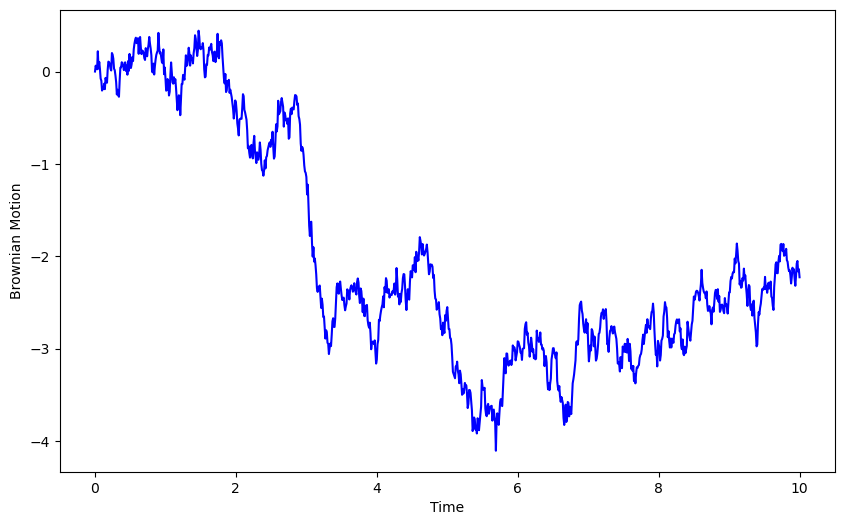

In [ ]:
import torch
import matplotlib.pyplot as plt

N = 1000
T = 10
d = 1
x0 = torch.tensor(0.0)
delta_t = T / N
batch = 1
z = torch.randn([batch, N, d])

Bt = torch.ones([batch, N+1, d]) * x0
for i in range(N):
    Bt[:, i+1] = Bt[:, i] + torch.sqrt(torch.tensor(delta_t)) * z[:, i]

# Plotting Brownian motion
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.plot(torch.linspace(0, T, N+1), Bt[j, :, 0].numpy(), color='blue', alpha=1.0)

plt.xlabel('Time')
plt.ylabel('Brownian Motion')

plt.show()

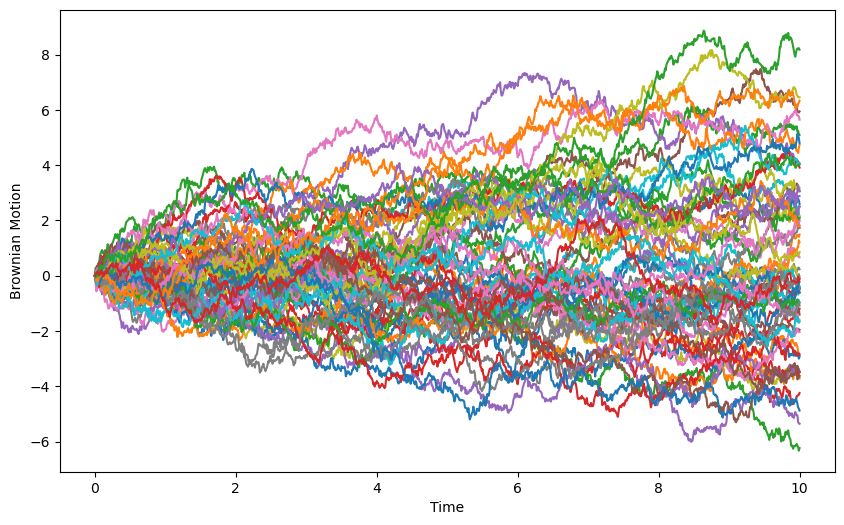

In [ ]:
import torch
import matplotlib.pyplot as plt
N = 1000
T = 10
d = 1
x0 = torch.tensor(0.0)
delta_t = T / N
batch = 64
z = torch.randn([batch, N, d])
Bt = torch.ones([batch, N+1, d]) * x0
for i in range(N):
    Bt[:, i+1] = Bt[:, i] + torch.sqrt(torch.tensor(delta_t)) * z[:, i]
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.plot(torch.linspace(0, T, N+1), Bt[j, :, 0].numpy(), alpha=1.0)

plt.xlabel('Time')
plt.ylabel('Brownian Motion')

plt.show()

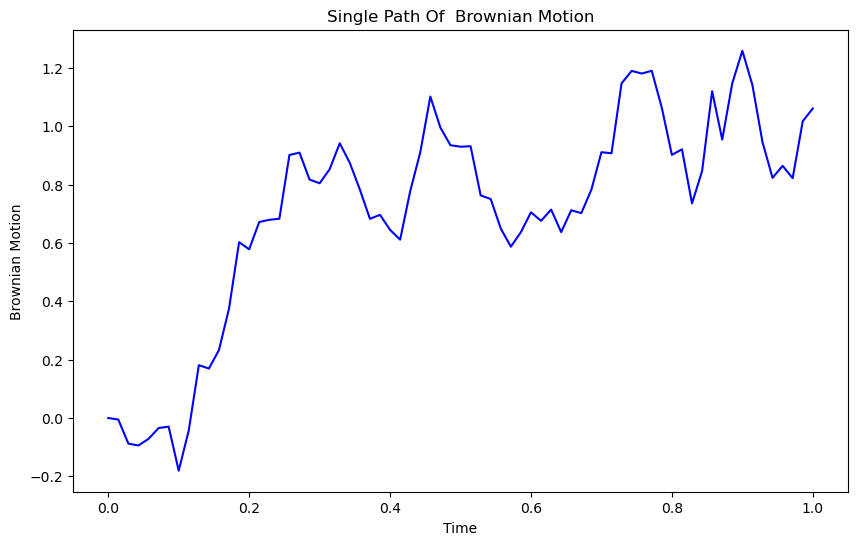

In [ ]:
import torch
import matplotlib.pyplot as plt

N = 70
T = 1
d = 1
x0 = torch.tensor(0.0)
delta_t = T / N
batch = 1
z = torch.randn([batch, N, d])

Bt = torch.ones([batch, N+1, d]) * x0


for i in range(N):
    Bt[:, i+1] = Bt[:, i] + torch.sqrt(torch.tensor(delta_t)) * z[:, i]

# Plotting Brownian motion
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.plot(torch.linspace(0, T, N+1), Bt[j, :, 0].numpy(), color='blue', alpha=1.0)
plt.title('Single Path Of  Brownian Motion')
plt.xlabel('Time')
plt.ylabel('Brownian Motion')

plt.show()

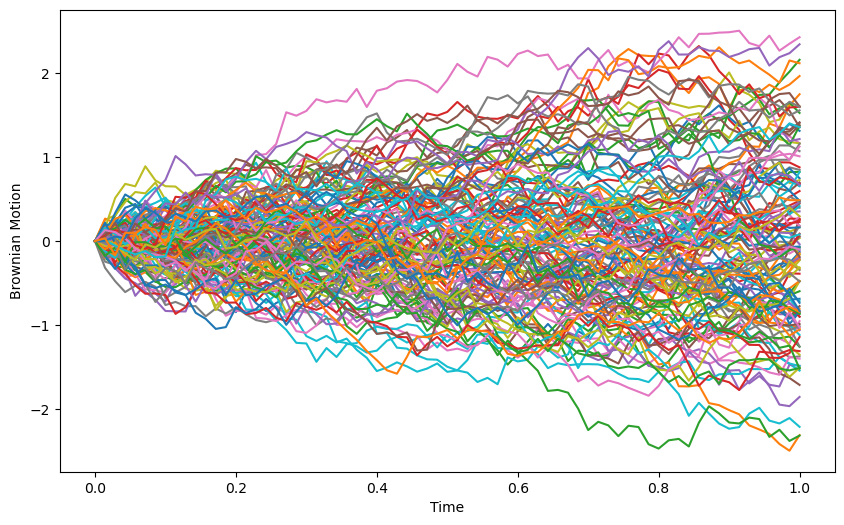

In [ ]:
import torch
import matplotlib.pyplot as plt
N = 70
T = 1
d = 1
x0 = torch.tensor(0.0)
delta_t = T / N
batch = 132
z = torch.randn([batch, N, d])
Bt = torch.ones([batch, N+1, d]) * x0
for i in range(N):
    Bt[:, i+1] = Bt[:, i] + torch.sqrt(torch.tensor(delta_t)) * z[:, i]
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.plot(torch.linspace(0, T, N+1), Bt[j, :, 0].numpy(), alpha=1.0)

plt.xlabel('Time')
plt.ylabel('Brownian Motion')
plt.show()


##Algorithm 2-2 Simulation of Compound Poisson Process

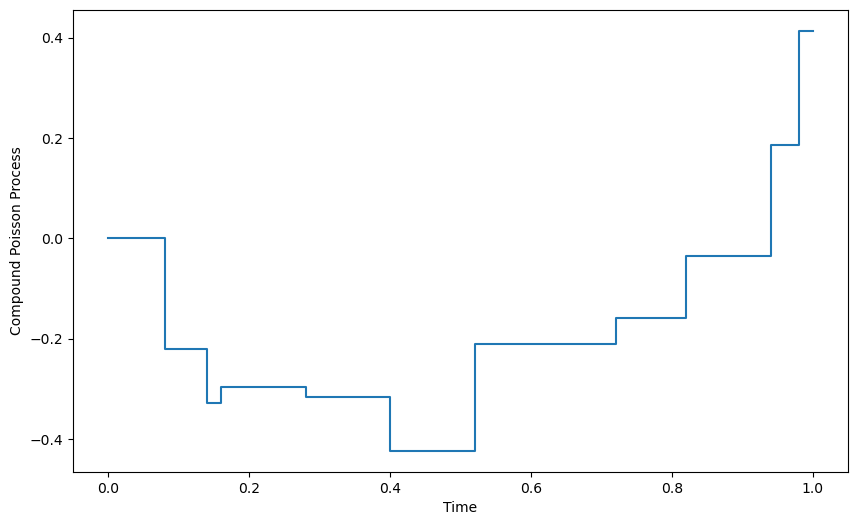

In [ ]:
import torch
import matplotlib.pyplot as plt
from scipy.special import gamma

class CPP():
    def __init__(self, T, alpha, r, d):
        self.T = torch.tensor(T)
        self.alpha = torch.tensor(alpha)
        self.r = torch.tensor(r)
        self.d = torch.tensor(d)
        self.c = 2**alpha * gamma((d + alpha) / 2) / torch.pi**(d / 2) / torch.abs(torch.tensor(gamma(-alpha / 2)))
        self.k = torch.pi**(d / 2) * r**(2 - alpha) / (gamma(d / 2 + 1) * (2 - alpha))
        self.cr = alpha * gamma(d / 2) * r**alpha / (2 * torch.pi**(d / 2))
        M = int(d / 2) - 1
        if M <= 0:
            self.cc = 2**(alpha + 1) / torch.abs(torch.tensor(gamma(-alpha / 2))) / alpha / r**alpha * gamma((alpha + d) / 2) / gamma(d / 2)
            self.sigma = torch.sqrt(2**alpha * r**(2 - alpha) * gamma((d + alpha) / 2) / gamma(d / 2 + 1) / torch.abs(torch.tensor(gamma(-alpha / 2))) / (2 - alpha))
        else:
            self.cc = 2**(alpha + 1) / torch.abs(torch.tensor(gamma(-alpha / 2))) / alpha / r**alpha * gamma((alpha + d) / 2 - M) / gamma(d / 2 - M)
            self.sigma = torch.sqrt(2**alpha * r**(2 - alpha) * gamma((d + alpha) / 2 - M) / gamma(d / 2 + 1 - M) / torch.abs(torch.tensor(gamma(-alpha / 2))) / (2 - alpha))
            for k in range(M):
                self.cc *= (d + alpha - 2 * (k + 1)) / (d - 2 * (k + 1))
                self.sigma *= torch.sqrt(torch.tensor((d + alpha - 2 * (k + 1)) / (d + 2 - 2 * (k + 1))))

    def power_law_dis(self, batch):
        jump_size = self.r * (1 - (torch.rand([batch, 1]))) ** (-1 / self.alpha)
        if self.d == 1:
            return torch.sign(torch.randn([batch, 1])) * jump_size
        else:
            theta = torch.pi * torch.rand([batch, self.d - 2])
            phi = 2 * torch.pi * torch.rand([batch, 1])
            angles = torch.cat([theta, phi], dim=-1)
            component = []
            for i in range(self.d):
                if i == 0:
                    component.append(jump_size * torch.cos(angles[:, i:i+1]))
                elif i == self.d - 1:
                    sin_product = torch.prod(torch.sin(angles[:, :i]), dim=1, keepdim=True)
                    component.append(jump_size * sin_product)
                else:
                    sin_product = torch.prod(torch.sin(angles[:, :i]), dim=1, keepdim=True)
                    component.append(jump_size * sin_product * torch.cos(angles[:, i:i+1]))
            return torch.cat(component, dim=1)

    def C_process(self, x, batch, N):
        dt = self.T / N
        jump_size = torch.zeros([batch, N, self.d])
        Lt = torch.ones([batch, N + 1, self.d]) * x
        num_jumps = torch.poisson(torch.ones([batch, N]) * self.cc * dt).int()

        # Loop over time steps to simulate the process
        for i in range(N):
            Nt = num_jumps[:, i]
            jump_size_batch = self.power_law_dis(Nt.sum())

            # Properly manage the indexing for jump sizes
            ind = torch.cumsum(torch.cat([torch.tensor([0]), Nt]), dim=0)

            # Sum up the jump sizes and update the process
            for j in range(batch):
                jump_size[j, i] = torch.sum(jump_size_batch[ind[j]:ind[j + 1]], dim=0)

            Lt[:, i + 1] = Lt[:, i] + jump_size[:, i]

        return Lt

# Parameters
N = 50      # Number of time steps
T = 1       # Time horizon
d = 1       # Dimension
alpha = 1.5 # Jump distribution parameter
r = 0.08    # Scaling factor for jumps

batch = 1   # Number of simulations (batch size)
x = torch.tensor(0.0)  # Initial position
times = torch.linspace(0, T, N + 1)  # Time grid

# Initialize and simulate the process
fpde = CPP(T, alpha, r, d)
Xt = fpde.C_process(x, batch, N)

# Plotting the process
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.step(times.numpy(), Xt[j, :, 0].cpu().numpy(), where='post', alpha=1.0)
plt.xlabel('Time')
plt.ylabel('Compound Poisson Process')
plt.title('Compound Poisson Process with Power-Law Jumps')
plt.show()

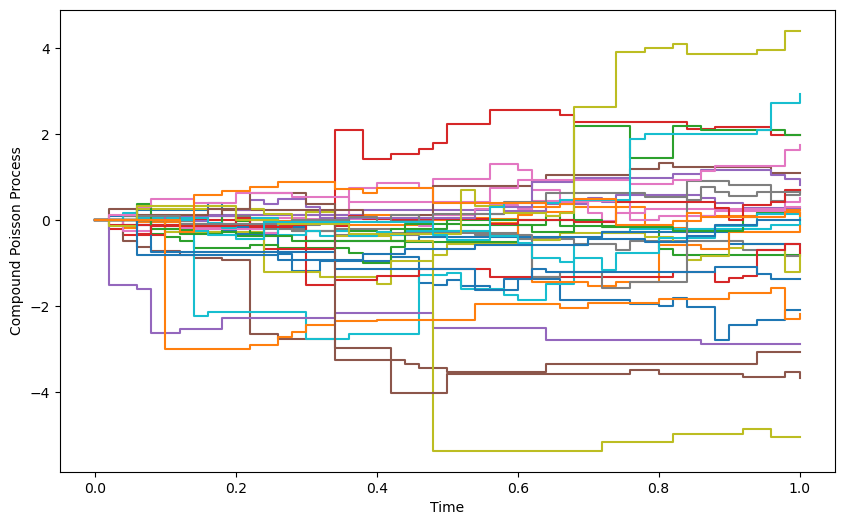

In [ ]:

N = 50
T = 1
d = 1
alpha = 1.5
r = 0.08

batch = 32
x = torch.tensor(0)
times = torch.linspace(0, T, N + 1)
fpde = CPP(T, alpha, r, d)
Xt = fpde.C_process(x, batch, N)
# Plotting the process
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.step(times.numpy(), Xt[j, :, 0].cpu().numpy(), where='post', alpha=1.0)
plt.xlabel('Time')
plt.ylabel('Compound Poisson Process')
plt.show()


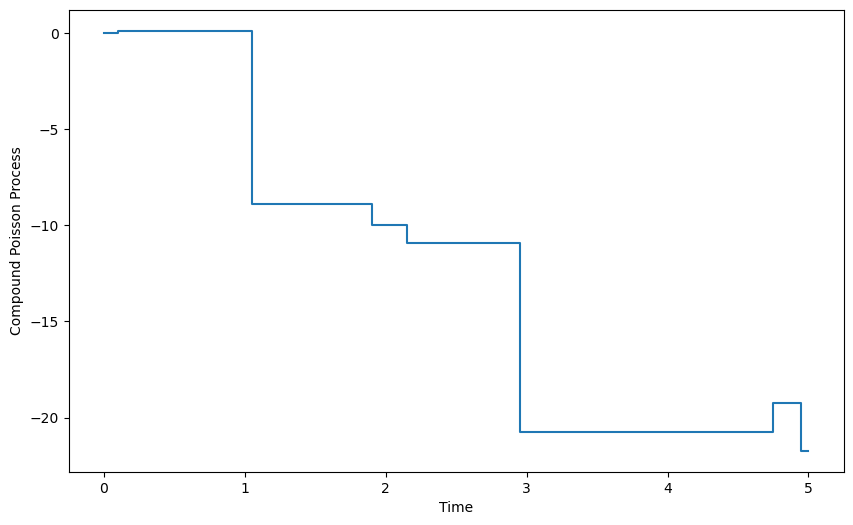

In [ ]:

N = 100
T = 5
d = 1
alpha = 0.9
r = 0.8

batch = 1
x = torch.tensor(0)
times = torch.linspace(0, T, N + 1)
fpde = CPP(T, alpha, r, d)
Xt = fpde.C_process(x, batch, N)

# Plotting the process
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.step(times.numpy(), Xt[j, :, 0].cpu().numpy(), where='post', alpha=1.0)
plt.xlabel('Time')
plt.ylabel('Compound Poisson Process')
plt.show()


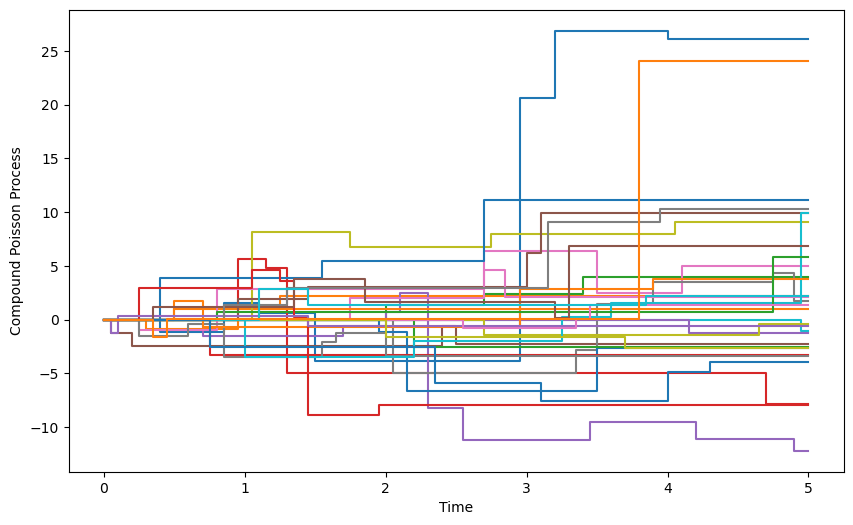

In [ ]:

N = 100
T = 5
d = 1
alpha = 0.9
r = 0.8

batch = 32
x = torch.tensor(0)
times = torch.linspace(0, T, N + 1)
fpde = CPP(T, alpha, r, d)
Xt = fpde.C_process(x, batch, N)

# Plotting the process
plt.figure(figsize=(10, 6))
for j in range(batch):
    plt.step(times.numpy(), Xt[j, :, 0].cpu().numpy(), where='post', alpha=1.0)
plt.xlabel('Time')
plt.ylabel('Compound Poisson Process')
plt.show()
